In [27]:
import os
import glob
import json
import pandas as pd
import log_codes as log
import log_print_functions as log_print
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

directory_path = './logs/dut0_ecc_bypass/logs_client'
file_pattern = 'Client_dut*'

if directory_path == './logs/dut0_ecc_bypass/logs_client':
    valid_runs = [13,14,15,16]
else:
    valid_runs = [1,2,3,4]

# Use glob to find all files matching the pattern
file_paths = glob.glob(os.path.join(directory_path, file_pattern))

def parse_files(file_paths):
    frames = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            for json_line in file:
                # Parse frame
                try:
                    frame = json.loads(json_line)
                except Exception as error:
                    print(f"Failed decoding JSON for file {file_path}: {error}")
                frames.append(frame)
    return frames

frames_original = sorted(parse_files(file_paths), key=lambda x: x["timestamp"])
raw_df = pd.DataFrame(frames_original)

### Converting Unix timestamp to UTC

And droping any duplicates.... Why do we do this though?????

In [28]:
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'], unit='s').dt.tz_localize('UTC')
# raw_df = raw_df.drop_duplicates()
# raw_df

## Custom frame decoding

In ```log_codes.py``` you can create the dictionary that holds the frame formatting for a given frame ID. This will be custom to your specific frame. Find the documentation for each field in payload_parser. 

Also define the keys for each element.

Now, parse the fields based on frame type and then parsing the data tuple into readable fields


In [29]:

# Parse raw frame into executions
execution_df = log.parse_data(raw_df)
try:
    execution_df['timestamp'] = pd.to_datetime(execution_df['timestamp']).dt.tz_localize('UTC')
except Exception as error:
    print(f"Error converting timestamp to datetime: {error}")



# Separate into runs

Now that we have the events correctly embedded in the data, we separate the runs according to events.

Each timeout event generates a discontinuity in the data. Each discontinuity is a new run. We remove runs that are composed only of events. 

In [30]:

list_of_runs = []
start_index = 0
for index, row in execution_df.iterrows():
    if row['event'] == log.ERROR_TIMEOUT:
        sliced_df = execution_df[start_index:index]
        list_of_runs.append(sliced_df)
        start_index = index
sliced_df = execution_df[start_index:]
list_of_runs.append(sliced_df)
print(f"Number of valid runs = {len(list_of_runs)}")

# Remove invalid runs
list_of_runs = [df for df in list_of_runs if not all(df['event'] != 0)]
print(f"Number of valid runs = {len(list_of_runs)}")
# Remove timeout from run slice
for i in range(len(list_of_runs)):
    if len(list_of_runs[i]) > 0 and list_of_runs[i].iloc[0]['event'] == 5:
        list_of_runs[i] = list_of_runs[i].iloc[1:]

#Number of runs
print(f"Number of valid runs = {len(list_of_runs)}")
# list_of_runs[19]

Number of valid runs = 53
Number of valid runs = 22
Number of valid runs = 22


In [31]:
# filtered_df = list_of_runs[-1][list_of_runs[-1]['timestamp'].dt.hour >= 15]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.hour < 16]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.minute >= 0]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.minute <=58]


filtered_df = list_of_runs[-1].loc[:, ['timestamp', 'imem_se', 'imem_de', 'dmem_se', 'dsp_t', 'iv']]
filtered_df = filtered_df.drop_duplicates(subset=filtered_df.columns.difference(['timestamp']))
# filtered_df


-------------

# Data Analysis

Using ```list_of_runs``` as input

### Timestamps and totals for each run

Get start, end, and total number of errors for each run

In [32]:
index = 0

for df in list_of_runs:
    start = df.iloc[0]['timestamp']
    end = df.iloc[-1]['timestamp']
    total_time = end - start
    total_imem_de = df['imem_de'].sum()
    total_dsp_t = df['dsp_t'].sum()
    total_errors = df['total_errors'].sum()
    # total_errors = df['imem_se'].sum()
    # print(start.hour)

    
    if start.hour > 10 or (start.hour >= 10 and start.minute >= 30):
        start_str = start.strftime("%d %H:%M:%S.%f")[:-3]  # Limit seconds to 2 decimal places
        end_str = end.strftime("%H:%M:%S.%f")[:-3]  # Limit seconds to 2 decimal places
        duration = round((end - start).total_seconds(), 1)  # Limit duration to 2 decimal places
        if duration > 60:
            print(f"{index} \t| Duration = {duration}  \t| Start: \t{start_str} -- {end_str}")
        # print(f"Start: \t{start_str}")
        # print(f"End: \t{end_str}")
    # print(f"Total Time: {total_time}")
    # print(f"Total Errors: {total_errors}")
    # print(f"Total dsp_t: {total_dsp_t}")
    # print(f"Total imem_de: {total_imem_de}")
    # print()
    index += 1


13 	| Duration = 12715.6  	| Start: 	07 10:35:17.102 -- 14:07:12.658
14 	| Duration = 15759.5  	| Start: 	07 14:08:09.218 -- 18:30:48.747
15 	| Duration = 2909.8  	| Start: 	07 18:31:49.707 -- 19:20:19.482
16 	| Duration = 14542.5  	| Start: 	07 19:21:15.950 -- 23:23:38.401
17 	| Duration = 108.5  	| Start: 	07 23:24:22.796 -- 23:26:11.269
18 	| Duration = 1491.2  	| Start: 	07 23:50:53.179 -- 00:15:44.379
21 	| Duration = 23018.4  	| Start: 	08 10:43:38.403 -- 17:07:16.828


3


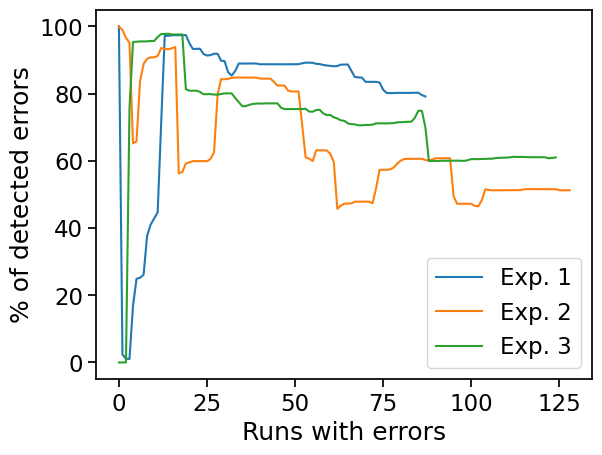

71.61 15.8
./logs/dut0_ecc_bypass/logs_client


In [33]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_context("notebook", font_scale=1.5)
list_of_ratios = []
for i in valid_runs:

    filtered_df = list_of_runs[i][list_of_runs[i]['timestamp'].dt.day == 7]
    # filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(10,35)]
    # filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(13,6)]
    filtered_df = filtered_df[filtered_df['imem_se'] > 0]

    ##########################################################################

    selected_columns_df = filtered_df[['iv', 'imem_se']].copy()

    selected_columns_df["increment_se"] = selected_columns_df["imem_se"].diff()
    selected_columns_df["increment_iv"] = selected_columns_df["iv"].diff()

    # Remove rows with a value of 0 in the "increment_iv" column
    selected_columns_df = selected_columns_df[(selected_columns_df["increment_iv"] != 0) | (selected_columns_df["increment_se"] != 0)]
    selected_columns_df = selected_columns_df[(selected_columns_df["increment_iv"] != 1) | (selected_columns_df["increment_se"] != 1)]
    selected_columns_df = selected_columns_df[~((selected_columns_df["increment_iv"] == 0) & (selected_columns_df["increment_se"] == 1)) &
                                            ~((selected_columns_df["increment_iv"] == 1) & (selected_columns_df["increment_se"] == 0)) &
                                            ~((selected_columns_df["increment_iv"] < 0) & (selected_columns_df["increment_se"] == 0)) &
                                            ~((selected_columns_df["increment_iv"] == 0) & (selected_columns_df["increment_se"] < 0))]

    # selected_columns_df = selected_columns_df[selected_columns_df["increment_iv"] > 0]
    selected_columns_df = selected_columns_df[selected_columns_df["increment_se"] >= 0]
    
    # selected_columns_df = selected_columns_df[selected_columns_df["increment_iv"] < 4000]
    # selected_columns_df = selected_columns_df[selected_columns_df["increment_se"] < 4000]

    # Count the number of rows where the values in the two columns are equal
    # Count the number of rows where the values in the two columns are different
    selected_columns_df["ratio_iv"] = selected_columns_df["iv"] / selected_columns_df["imem_se"] *100
    # selected_columns_df['equal'] = (selected_columns_df['increment_iv'] == selected_columns_df['increment_se']).astype(int)

    # Calculate the absolute difference between the two columns
    absolute_difference = abs(selected_columns_df['increment_iv'] - selected_columns_df['increment_se'])

    # Calculate the threshold value
    threshold_percentage = 0.1  # 90% threshold
    threshold_value = selected_columns_df['increment_iv'] * threshold_percentage

    # Check if the absolute difference is within the threshold
    selected_columns_df['equal'] = (absolute_difference <= threshold_value).astype(int)


    different_count = (selected_columns_df["increment_se"] != selected_columns_df["increment_iv"]).sum()
    equal_count = (selected_columns_df["increment_se"] == selected_columns_df["increment_iv"]).sum()
    # Display the results
    # print("Number of rows where the values are equal:", equal_count)
    # print("Number of rows where the values are different:", different_count)
    # print("Ratio:", equal_count/different_count)

    # remove specific corner case with bit flip in counter
    selected_columns_df = selected_columns_df[selected_columns_df["ratio_iv"] <= 100]
    
    # display(selected_columns_df)
    
    list_of_ratios.append(selected_columns_df["ratio_iv"])

    # display(selected_columns_df)

# Select the elements you want to concatenate
if len(list_of_ratios) > 1:
    concatenated_df = pd.concat([list_of_ratios[1], list_of_ratios[2]])

    streamlined_list_of_ratios = [list_of_ratios[0],concatenated_df,list_of_ratios[3]]
else:
    streamlined_list_of_ratios = list_of_ratios

print(len(streamlined_list_of_ratios))
##########################################################################

# Create a line plot for each experiment
for idx, ratios in enumerate(streamlined_list_of_ratios):
    ratios = ratios.reset_index(drop=True)
    sns.lineplot(data=ratios, label=f'Exp. {idx+1}')

# Set x and y labels
plt.xlabel('Runs with errors')
plt.ylabel('% of detected errors')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()

selected_columns_df.loc[(filtered_df["iv"] == 0) & (selected_columns_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(selected_columns_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(selected_columns_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)
print(directory_path)


       inc_dmem_se
count    62.000000
mean    120.919355
std     216.446889
min       1.000000
25%       1.000000
50%      50.000000
75%     105.000000
max    1082.000000
Mean error per second 21.213921901528014
Max error per second 189.82456140350877


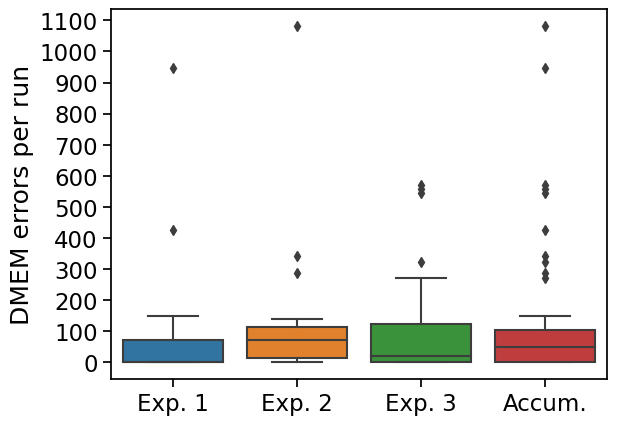

./logs/dut0_ecc_bypass/logs_client


In [34]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

dataframes_list = []

for i in valid_runs:

    filtered_df = list_of_runs[i][list_of_runs[i]['timestamp'].dt.day == 7]
    # filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(10,35)]
    # filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(13,6)]
    selected_columns_df = filtered_df[['dmem_se']].copy()

    selected_columns_df["inc_dmem_se"] = selected_columns_df["dmem_se"].diff()

    selected_columns_df = selected_columns_df.drop(columns=['dmem_se'])

    selected_columns_df["time"] = list_of_runs[i]['timestamp']
    # Convert the timestamp column to datetime type
    selected_columns_df['time'] = pd.to_datetime(selected_columns_df['time'])

    # Format the timestamp column to display only the day and the time with two decimal places
    selected_columns_df['time'] = selected_columns_df['time'].dt.strftime('%H:%M:%S.%f').str[:-7]

    # selected_columns_df = selected_columns_df[(selected_columns_df > 0).any(axis=1)]
    # Get the columns that have "increment_" in their names
    increment_columns = [col for col in selected_columns_df.columns if 'inc_' in col]

    # Check if any value in any of the increment columns is not equal to 0
    selected_columns_df = selected_columns_df[(selected_columns_df[increment_columns] > 0).any(axis=1)]

    # display(selected_columns_df)

    # Convert the 'time' column to datetime type
    selected_columns_df['time'] = pd.to_datetime(selected_columns_df['time'])

    # Calculate the total value for each column
    total_values = selected_columns_df.drop(columns=['time']).sum()

    # Calculate the total time elapsed from start to end (in minutes)
    total_time_elapsed_minutes = (selected_columns_df['time'].iloc[-1] - selected_columns_df['time'].iloc[0]).total_seconds() / 60

    # Divide the total value for each column by the total time elapsed (in minutes)
    result = total_values / total_time_elapsed_minutes *60

    # print(result)
    mean_ratio_iv = round(selected_columns_df['inc_dmem_se'].mean(), 2)
    std_ratio_iv = round(selected_columns_df['inc_dmem_se'].std(), 2)

    # print(mean_ratio_iv, std_ratio_iv)

    dataframes_list.append(selected_columns_df)

    percentiles = np.percentile(selected_columns_df['inc_dmem_se'], [10, 25, 50, 75, 95])

    # print("10th percentile: {:.2f}".format(percentiles[0]))
    # print("25th percentile (Q1): {:.2f}".format(percentiles[1]))
    # print("50th percentile (Median): {:.2f}".format(percentiles[2]))
    # print("75th percentile (Q3): {:.2f}".format(percentiles[3]))
    # print("95th percentile: {:.2f}".format(percentiles[4]))


# Select the elements you want to concatenate
if len(dataframes_list) > 1:
    concatenated_df = pd.concat([dataframes_list[1], dataframes_list[2]])

    streamlined_list_of_ratios = [dataframes_list[0],concatenated_df,dataframes_list[3]]
else:
    streamlined_list_of_ratios = dataframes_list

# Initialize an empty list to store data
concat_data = []
combined_df = pd.concat(streamlined_list_of_ratios, ignore_index=True)
streamlined_list_of_ratios.append(combined_df)
# Iterate over each DataFrame in dataframes_list
for i, df in enumerate(streamlined_list_of_ratios):
    # Extract the 'inc_dmem_se' column and convert it into a DataFrame with a new column for the dataset identifier
    temp_df = df[['inc_dmem_se']].copy()  # Ensure you're working with a copy to avoid SettingWithCopyWarning
    temp_df['Experiment'] = f'Exp. {i+1}'
    if i == 3:
        temp_df['Experiment'] = f'Accum.'
    
    # Append the modified DataFrame to the list
    concat_data.append(temp_df)

# Concatenate the list of DataFrames into a new DataFrame, ignoring the index to avoid issues with different lengths
new_df = pd.concat(concat_data, ignore_index=True)

# Rename columns for clarity if needed
new_df.columns = ['DMEM errors per run', 'Experiment']

# Create the box plot
ax = sns.boxplot(x='Experiment', y='DMEM errors per run', data=new_df)
# Get the numerical values of the percentiles
percentiles = concat_data[-1].describe(percentiles=[0.25, 0.5, 0.75])

# Print the percentiles
print(percentiles)
mean_value = percentiles.loc['mean'].values[0]
max_value = percentiles.loc['max'].values[0]
print("Mean error per second {}".format(mean_value/5.7))
print("Max error per second {}".format(max_value/5.7))

# Remove the x-axis label
ax.set_xlabel('')
# Manually set y-axis ticks
plt.yticks(range(0, 1150, 100))  # Adjust the step as needed

plt.show()
print(directory_path)


# Mixing 2 runs

In [35]:
previous_run = streamlined_list_of_ratios.copy()

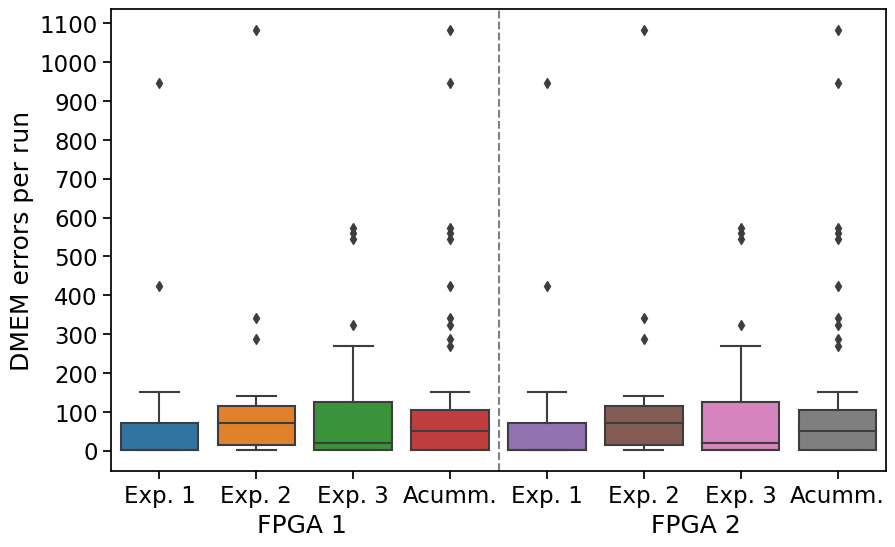

./logs/dut0_ecc_bypass/logs_client


In [36]:
# Initialize an empty list to store data
previous_run.extend(streamlined_list_of_ratios)

concat_data = []

# previous_run.append(combined_df)
# Iterate over each DataFrame in dataframes_list
for i, df in enumerate(previous_run):
    # Extract the 'inc_dmem_se' column and convert it into a DataFrame with a new column for the dataset identifier
    temp_df = df[['inc_dmem_se']].copy()  # Ensure you're working with a copy to avoid SettingWithCopyWarning
    temp_df['Experiment'] = f'Exp. {i+1}'
    if i == 3:
        temp_df['Experiment'] = f'Accum.'
    
    # Append the modified DataFrame to the list
    concat_data.append(temp_df)

# Concatenate the list of DataFrames into a new DataFrame, ignoring the index to avoid issues with different lengths
new_df = pd.concat(concat_data, ignore_index=True)

# Rename columns for clarity if needed
new_df.columns = ['DMEM errors per run', 'Experiment']

plt.figure(figsize=(10, 6))

# Create the box plot
ax = sns.boxplot(x='Experiment', y='DMEM errors per run', data=new_df)

# Remove the x-axis label
ax.set_xlabel('')

# Customize the x-axis ticks and labels
positions = [0, 1, 2, 3, 4, 5, 6, 7]  # Manually set the positions for each box plot
plt.xticks(positions, ['Exp. 1', 'Exp. 2', 'Exp. 3', 'Acumm.', 'Exp. 1', 'Exp. 2', 'Exp. 3', 'Acumm.'])
plt.xlabel("FPGA 1                                      FPGA 2")  # Add x-axis label

# Manually set y-axis ticks
plt.yticks(range(0, 1150, 100))  # Adjust the step as needed

# Add a line or any visual separator between the groups
plt.axvline(x=3.5, color='gray', linestyle='--')  # Add a vertical line between the first and last 4 groups

plt.show()
print(directory_path)

# Agreement rate

Number of rows where the values are equal: 51
Number of rows where the values are different: 37
Ratio: 1.3783783783783783
Number of rows where the values are equal: 46
Number of rows where the values are different: 39
Ratio: 1.1794871794871795
Number of rows where the values are equal: 9
Number of rows where the values are different: 32
Ratio: 0.28125
Number of rows where the values are equal: 74
Number of rows where the values are different: 49
Ratio: 1.510204081632653
57.95454545454546 3.4090909090909087 38.63636363636363
43.65079365079365 19.047619047619047 37.301587301587304
60.16260162601627 3.2520325203252036 36.58536585365853


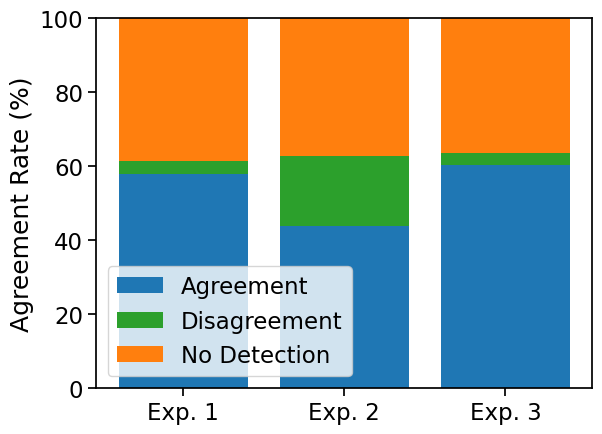

./logs/dut0_ecc_bypass/logs_client


In [37]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

list_of_ratios = []
# valid_runs = [13]
for i in valid_runs:

    filtered_df = list_of_runs[i][list_of_runs[i]['timestamp'].dt.day == 7]
    # filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(10,35)]
    # filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(13,6)]
    filtered_df = filtered_df[filtered_df['imem_se'] > 0]

    ##########################################################################

    selected_columns_df = filtered_df[['iv', 'imem_se']].copy()

    selected_columns_df["increment_se"] = selected_columns_df["imem_se"].diff()
    selected_columns_df["increment_iv"] = selected_columns_df["iv"].diff()

    # Remove rows with a value of 0 in the "increment_iv" column
    selected_columns_df = selected_columns_df[(selected_columns_df["increment_iv"] != 0) | (selected_columns_df["increment_se"] != 0)]
    selected_columns_df = selected_columns_df[(selected_columns_df["increment_iv"] != 1) | (selected_columns_df["increment_se"] != 1)]
    selected_columns_df = selected_columns_df[~((selected_columns_df["increment_iv"] == 0) & (selected_columns_df["increment_se"] == 1)) &
                                            ~((selected_columns_df["increment_iv"] == 1) & (selected_columns_df["increment_se"] == 0)) &
                                            ~((selected_columns_df["increment_iv"] < 0) & (selected_columns_df["increment_se"] == 0)) &
                                            ~((selected_columns_df["increment_iv"] == 0) & (selected_columns_df["increment_se"] < 0))]

    selected_columns_df = selected_columns_df[selected_columns_df["increment_iv"] >= 0]
    selected_columns_df = selected_columns_df[selected_columns_df["increment_se"] >= 0]
    # selected_columns_df = selected_columns_df[selected_columns_df["increment_iv"] > 0]
    
    # Count the number of rows where the values in the two columns are different
    selected_columns_df["ratio_iv"] = selected_columns_df["iv"] / selected_columns_df["imem_se"] *100

    selected_columns_df['equal'] = np.where(selected_columns_df['increment_iv'] == selected_columns_df['increment_se'], 2,
                                        np.where(selected_columns_df['increment_iv'].astype(int) >= 1, 1, 0))

    different_count = (selected_columns_df["increment_se"] != selected_columns_df["increment_iv"]).sum()
    equal_count = (selected_columns_df["increment_se"] == selected_columns_df["increment_iv"]).sum()
    # Display the results
    print("Number of rows where the values are equal:", equal_count)
    print("Number of rows where the values are different:", different_count)
    print("Ratio:", equal_count/different_count)

    # remove specific corner case with bit flip in counter
    selected_columns_df = selected_columns_df[selected_columns_df["ratio_iv"] <= 100]
    # display(selected_columns_df)
    
    list_of_ratios.append(selected_columns_df)

# Select the elements you want to concatenate
if len(list_of_ratios) > 1:
    concatenated_df = pd.concat([list_of_ratios[1], list_of_ratios[2]])

    streamlined_list_of_ratios = [list_of_ratios[0],concatenated_df,list_of_ratios[3]]
else:
    streamlined_list_of_ratios = list_of_ratios

# Get the default Seaborn color palette
palette = sns.color_palette()
equal_color = palette[0]  # First color for 'Equal'
not_equal_color = palette[1]  # Second color for 'Not Equal'
zero_equal_color = palette[2]  # Second color for 'Not Equal'

# Initialize lists to store percentages
equal_percentages = []
not_equal_percentages = []
zero_percentages = []

# Iterate over each DataFrame in streamlined_list_of_ratios
for idx, df in enumerate(streamlined_list_of_ratios):
    # Calculate the percentage of 'equal' values for each DataFrame

    equal_percentage = count_of_twos = (df['equal'] == 2).sum()/len(df['equal']) *100
    not_equal_percentage = (df['equal'] == 1).sum()/len(df['equal'])*100
    zero_percentage = 100 - equal_percentage - not_equal_percentage
    
    print(equal_percentage, not_equal_percentage, zero_percentage)

    # Append percentages to lists
    equal_percentages.append(equal_percentage)
    not_equal_percentages.append(not_equal_percentage)
    zero_percentages.append(zero_percentage)

fig, ax = plt.subplots()

# Plot the first bar (Agreement)
ax.bar(range(len(streamlined_list_of_ratios)), equal_percentages, color=equal_color)

# Plot the second bar (Disagreement) on top of the first bar
ax.bar(range(len(streamlined_list_of_ratios)), not_equal_percentages, bottom=equal_percentages, color=zero_equal_color)

# Calculate the cumulative height of the first two bars (Agreement and Disagreement)
bottom_values = np.add(equal_percentages, not_equal_percentages)

# Plot the third bar (Third Element) on top of the first two bars
ax.bar(range(len(streamlined_list_of_ratios)), zero_percentages, bottom=bottom_values, color=not_equal_color)

# Set the labels and title
ax.set_ylabel('Agreement Rate (%)')

# Set the x-axis labels
ax.set_xticks(range(len(streamlined_list_of_ratios)))
ax.set_xticklabels([f'Exp. {i+1}' for i in range(len(streamlined_list_of_ratios))])

# Set the y-axis limits to make it 100% stacked
ax.set_ylim(0, 100)

# Add a legend
ax.legend(labels=['Agreement', 'Disagreement', 'No Detection'], loc='lower left')
# ax.legend(labels=['Agreement', 'Disagreement'], loc='lower left')

plt.show()
print(directory_path)